 #  Introdução


O Brasil é um país caracterizado por uma grande desigualdade social, sendo rico em recursos, mas com uma parcela significativa da população vivendo com uma renda mensal inferior a R$ 3000,00. Diante dessa realidade, este trabalho tem como objetivo investigar a influência de características sociais dos indivíduos na nota de redação do ENEM no ano de 2022. 

Para alcançar esse objetivo, utilizaremos algoritmos de marchine learning voltados para regressão e classificação. Nossa análise se concentrará em apenas 6 variáveis selecionadas para predizer a nota do ENEM, visando avaliar a qualidade e a viabilidade dos modelos utilizados.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
import os


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix
from sklearn.metrics import precision_score , accuracy_score

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier


import torch
import torch.nn as nn
import torch.optim as optim
import tqdm

%matplotlib inline

# configuração dos radades
from matplotlib import rc
# estilo dos gráficos #https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html
plt.style.use('seaborn-v0_8-dark')
%config InlineBackend.figure_format = 'retina'  # formato das imagens
rc('font', **{"family":"sans-serif","sans-serif":["DejaVu Sans"], "size":10})

rc('mathtext', **{"default":"regular"})

import warnings
warnings.filterwarnings("ignore")

# Variáveis sobre análise

O banco de dados do enem disponibiliza algumas informações que foram respondidas por quem se inscreveu na prova e as notas obtidas. Selecionamos as variáveis enumeradas a seguir para realizar a análise. 



    - TP_SEXO: Sexo
    - TP_COR_RACA: Cor/Raça
    - TP_ESCOLA: Estudade de Escola ou Privada
    - SG_UF_ESC: Estado da Federação

    - Q002: Até que série sua mãe, ou a mulher responsável por você, estudou?
        A	Nunca estudou.
        B	Não completou a 4ª série/5º ano do Ensino Fundamental.
        C	Completou a 4ª série/5º ano, mas não completou a 8ª série/9º ano do Ensino Fundamental.
        D	Completou a 8ª série/9º ano do Ensino Fundamental, mas não completou o Ensino Médio.
        E	Completou o Ensino Médio, mas não completou a Faculdade.
        F	Completou a Faculdade, mas não completou a Pós-graduação.
        G	Completou a Pós-graduação.
        H	Não sei.


    - Q006: Qual é a renda mensal de sua família? (Some a sua renda com a dos seus familiares.)
        A	Nenhuma Renda
        B	Até R$ 1.100,00
        C	De R$ 1.100,01 até R$ 1.650,00.
        D	De R$ 1.650,01 até R$ 2.200,00.
        E	De R$ 2.200,01 até R$ 2.750,00.
        F	De R$ 2.750,01 até R$ 3.300,00.
        G	De R$ 3.300,01 até R$ 4.400,00.
        H	De R$ 4.400,01 até R$ 5.500,00.
        I	De R$ 5.500,01 até R$ 6.600,00.
        J	De R$ 6.600,01 até R$ 7.700,00.
        K	De R$ 7.700,01 até R$ 8.800,00.
        L	De R$ 8.800,01 até R$ 9.900,00.
        M	De R$ 9.900,01 até R$ 11.000,00.
        N	De R$ 11.000,01 até R$ 13.200,00.
        O	De R$ 13.200,01 até R$ 16.500,00.
        P	De R$ 16.500,01 até R$ 22.000,00.
        Q	Acima de R$ 22.000,00.



    - Nota da Redação


Um destaque que percebemos que a única **variável numérica*** na pesquisa é a nota do enem, as outras são todas categóricas, ou seja, todas as nossas preditoras são de classificação. 


*O lado estatístico é mais forte, mas podemos escrever também Target Variable



In [2]:
# function to loading the file and with some transforms
def loading_file():
    df2022 = pd.read_csv("MICRODADOS_ENEM_2022.csv", sep= ";", encoding="latin-1", usecols=['TP_SEXO', 'TP_COR_RACA', 'TP_ESCOLA', 'SG_UF_ESC', 'Q006','NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO'])
    df2022 = df2022[df2022['NU_NOTA_REDACAO'] > 0]
    df2022 = df2022.dropna()
    df2022['TP_SEXO'] = df2022['TP_SEXO'].replace({0:'F', 1:'M'})
    df2022['TP_ESCOLA'] = df2022['TP_ESCOLA'].replace({2:'Publico', 3:'Privado'})
    df2022['TP_COR_RACA'] = df2022['TP_COR_RACA'].replace({0:'Não declarado', 1:'Branco', 2:'Preta', 3:'Parda', 4:'Amarela', 5:'Indígina', 6:'Não declarado'})
    return(df2022)

Após a implementação da função responsável por carregar o arquivo e realizar algumas transformações, foi decidido utilizar apenas as linhas que não possuem valores faltantes, resultando em um total de 659.252 indivíduos. Do ponto de vista estatístico, a exclusão das demais linhas não acarreta perda de informação relevante para o trabalho, uma vez que ainda estamos lidando com uma quantidade substancial de dados. No entanto, é importante ressaltar que, em pesquisas com uma quantidade menor de dados ou com uma significativa perda de linhas, o uso de técnicas de preenchimento de valores faltantes se torna necessário para garantir a integridade das informações.

In [3]:
# loadind the file
df2022 = loading_file()

# Regressão linear para as notas dos tipos de prova

Em pesquisas de trabalhos com o propósito parecido, achei estranho a utilização das notas das outras avaliações para predizer uma nota no ENEM. Como vemos no gráfico de correlação entre as notas, todas possuem correlação positiva, sendo a menor de 0.48 para as notas de redação e Ciências da Natureza. Não é uma correlação forte, mas indica que as características sociais dos participantes influenciam nas notas, mas existem particularidades  que levam o indivíduo obter nota melhor em Ciência da Natureza do que em Redação. 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


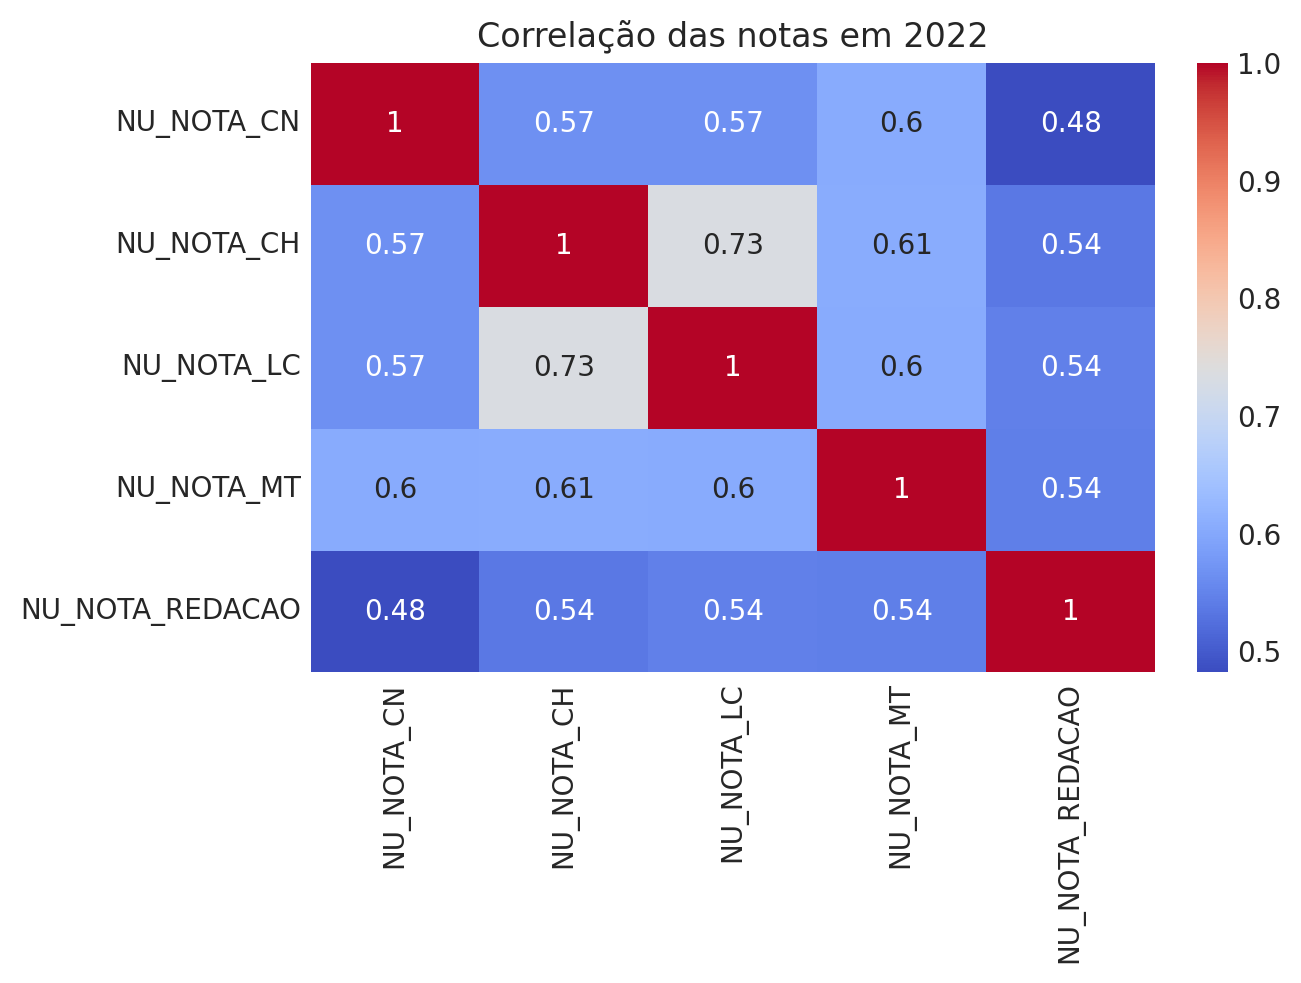

In [4]:
# function for regression
def linear_regression_comps():
    sample_2022_comps = df2022[['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO']].sample(n=2500, random_state= 1612)
    correlation_matrix = sample_2022_comps.corr()

    fig, ax = plt.subplots(constrained_layout=True)
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

   
    plt.legend(loc="upper right")
    plt.title('Correlação das notas em 2022')
    plt.show()

linear_regression_comps()

# Análise descritiva

Após carregar o arquivo, é importante realizar uma análise descritiva dos dados para compreender melhor o comportamento da nossa variável de interesse. Inicialmente, faremos uma análise geral, sem considerar categorias específicas, a fim de entender a distribuição dos valores. Em seguida, realizaremos uma análise mais detalhada, levando em consideração as variáveis selecionadas. Esse processo nos permitirá obter informações sobre os dados e entender melhor as características da nossa variável de interesse.

## Histograma das notas

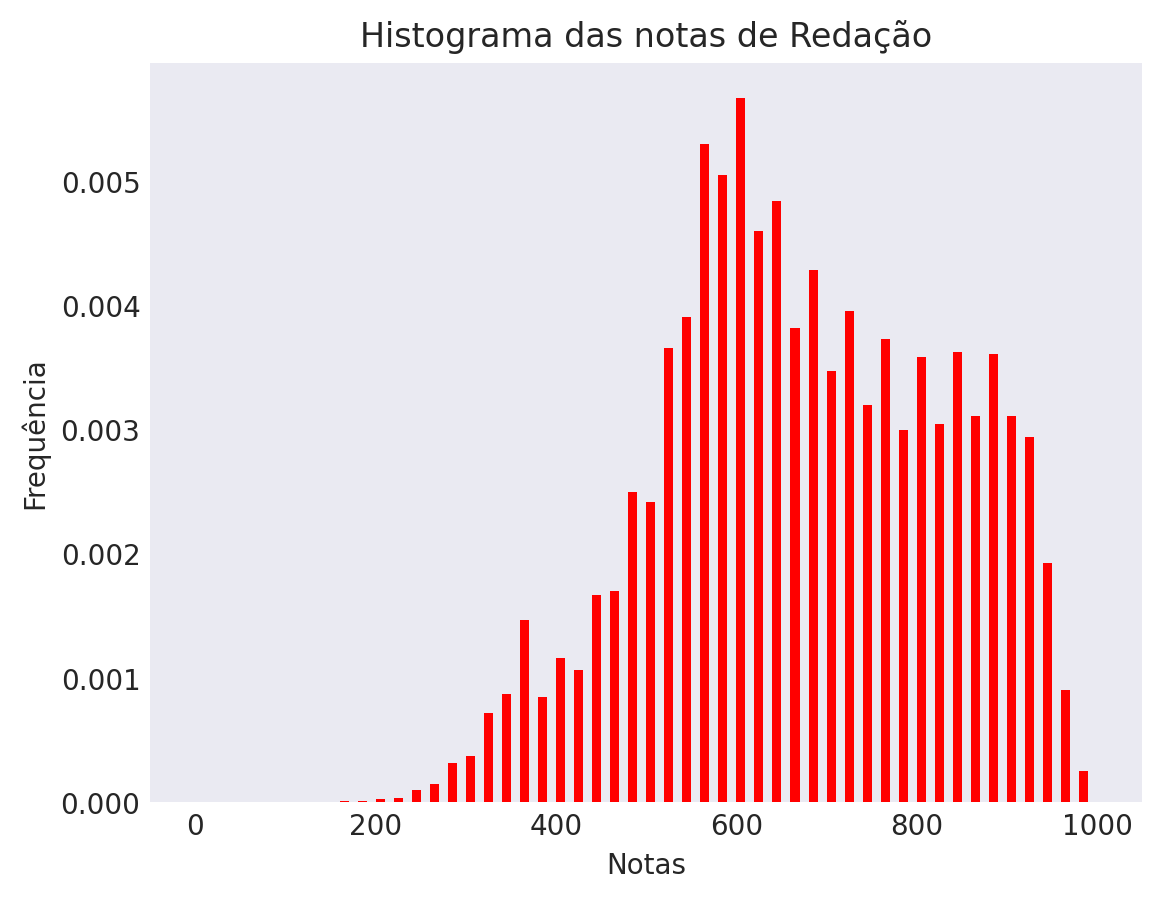

In [7]:
# chat for histogram
def histogram():
    start_value = 0 
    end_value = 1000  
    num_bins = 100

    plt.hist(df2022['NU_NOTA_REDACAO'], bins=num_bins, range=(start_value, end_value), color='red', density=True)

    # Add labels and title
    plt.xlabel('Notas')
    plt.ylabel('Frequência')
    plt.title('Histograma das notas de Redação')

    # Display the histogram
    plt.show()
    

histogram()


In [10]:
df2022['NU_NOTA_REDACAO'].describe().round(2).to_frame()

,NU_NOTA_REDACAO
count,659252.00
mean,666.79
std,158.68
min,40.00
25%,560.00
50%,660.00
75%,800.00
max,1000.00


Ao analisarmos o gráfico, podemos observar que a distribuição das notas não segue uma distribuição normal. Existe um crescimento significativo entre 400 e 600, representando o pico da distribuição das notas. A queda acentuada à direita ocorre após a nota 900.

Ao examinar as informações da função describe, podemos destacar que 25% das notas estão abaixo de 560 pontos, o que corresponde a mais da metade do total permitido na prova. No entanto, a mediana das notas é de 660, o que indica uma concentração de notas nesse intervalo. A média das notas é de 666,79 pontos.


## Notas por Cor/Raça

Para cor e raça, temos que a maior quantidade de inscritos é branco e também possui a maior média de nota, 698. Só brancos e pardos obtiveram a maior nota, 1000. Pode-se ver que os valores interquartis são próximos

In [6]:
df2022.groupby('TP_COR_RACA')['NU_NOTA_REDACAO'].describe()

,count,mean,std,min,25%,50%,75%,max
TP_COR_RACA,,,,,,,,
Amarela,11093.0,662.717029,159.398015,60.0,560.0,660.0,800.0,980.0
Branco,322573.0,698.090107,153.333127,40.0,580.0,700.0,820.0,1000.0
Indígina,2766.0,577.476500,146.586459,60.0,480.0,560.0,660.0,960.0
Não declarado,11195.0,633.856186,161.331401,40.0,520.0,620.0,760.0,980.0
Parda,252330.0,638.063726,158.711687,40.0,540.0,620.0,760.0,1000.0
Preta,59295.0,629.882452,152.935714,40.0,540.0,620.0,740.0,980.0


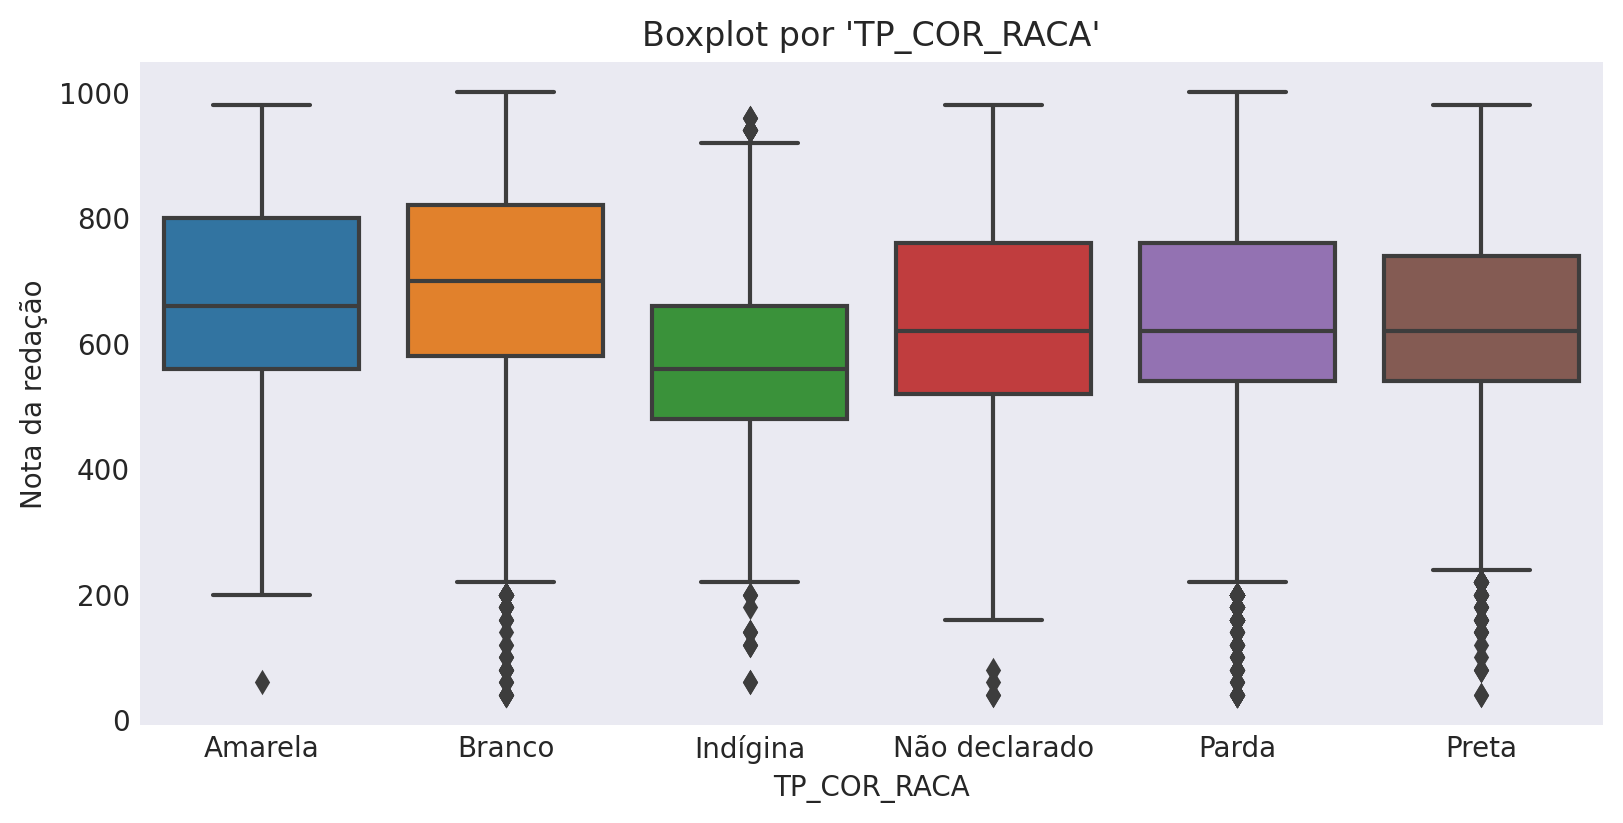

In [7]:

def boxplot_category(df2022, category):
    fig, ax = plt.subplots(constrained_layout=True)
    fig.set_size_inches(8, 4)

    sns.boxplot(x=category, y='NU_NOTA_REDACAO', data=df2022, order=sorted(df2022[category].unique()))

    ax.set_xlabel(category)
    ax.set_ylabel('Nota da redação')
    plt.title(f"Boxplot por '{category}'")
    
    # plt.xticks() 
    plt.show()

boxplot_category(df2022, 'TP_COR_RACA')

## TP_SEXO

Pelos valores obtidos, percebe-se que existe distinção não significativa entre as notas feminino e masculino. Destaca-se a diferença na quantidade de inscritos na análise entre homens e mulheres, próximo a 100 mil a mais para o sexo feminino

In [8]:
df2022.groupby('TP_SEXO')['NU_NOTA_REDACAO'].describe()

,count,mean,std,min,25%,50%,75%,max
TP_SEXO,,,,,,,,
F,370411.0,680.534487,160.861160,40.0,560.0,680.0,820.0,1000.0
M,288841.0,649.159572,154.046487,40.0,540.0,640.0,760.0,1000.0


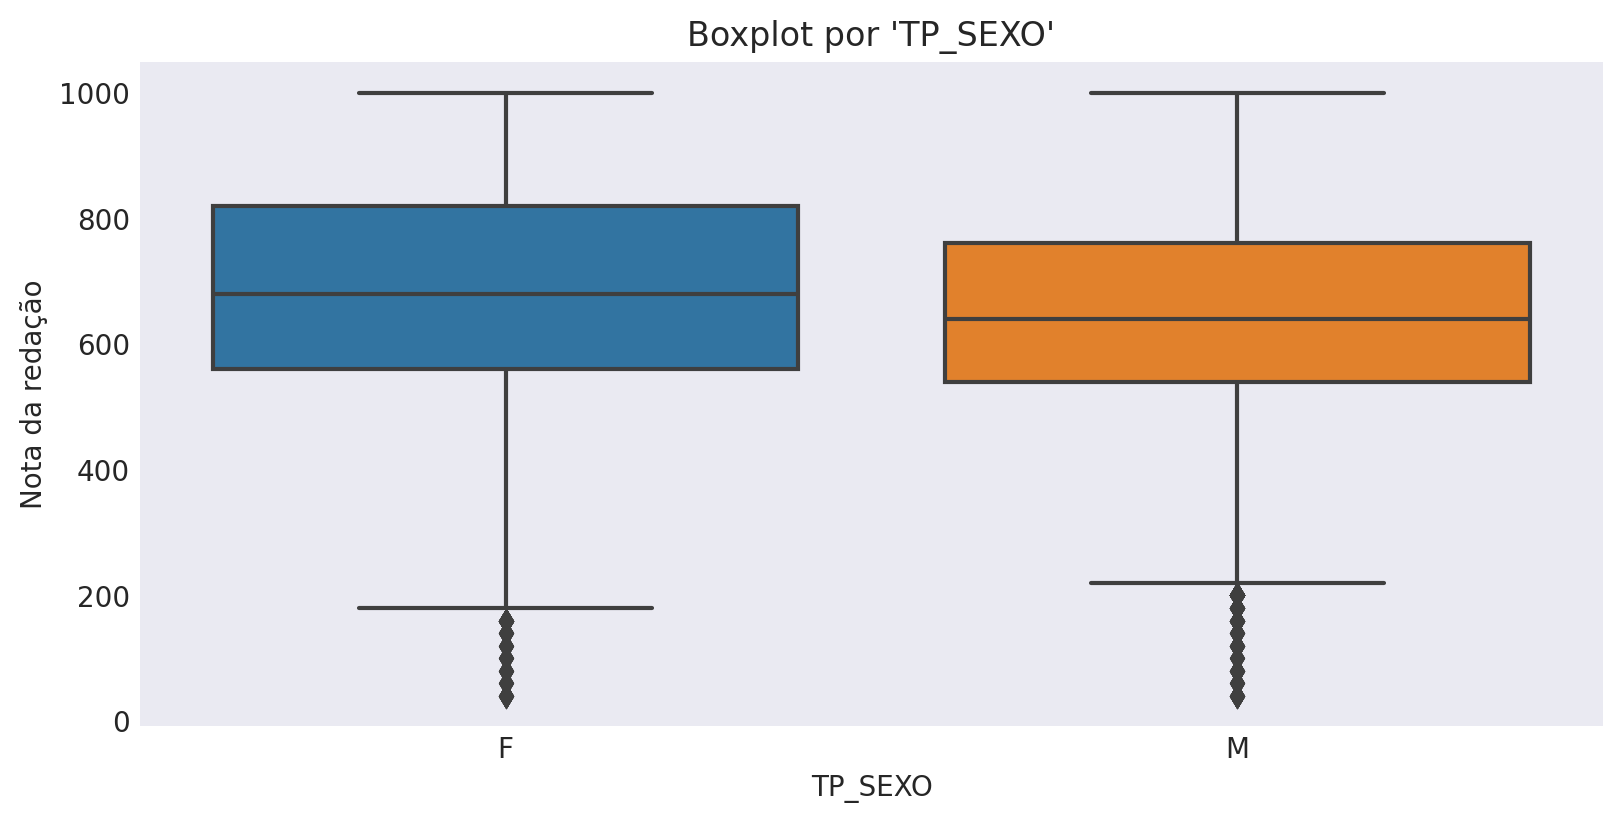

In [9]:
boxplot_category(df2022, 'TP_SEXO')

## Q006: Rendimento Familiar


Ao analisarmos as informações relacionadas à renda familiar dos indivíduos, observamos um padrão interessante: à medida que a renda familiar aumenta, há um crescimento na mediana das notas obtidas. Essa tendência também é observada no menor valor das notas, excluindo os outliers. Isso sugere que o desempenho na prova está correlacionado com o nível de renda financeira.

Para o grupo de maior porte financeiro, a média das notas é de 800, um valor bastante elevado, e a mediana é de 840. Por outro lado, para aqueles que informaram não possuir renda, a média das notas é de 576, e a mediana é de 560.

Essas informações indicam que o fator econômico desempenha um papel importante no desempenho dos indivíduos no exame, com aqueles de maior renda apresentando notas mais altas em comparação aos de menor renda.

In [10]:
df2022.groupby('Q006')['NU_NOTA_REDACAO'].describe()

,count,mean,std,min,25%,50%,75%,max
Q006,,,,,,,,
A,23986.0,576.420412,152.098881,40.0,480.0,560.0,660.0,980.0
B,150390.0,604.159984,152.507396,40.0,500.0,600.0,700.0,1000.0
C,94090.0,632.598363,150.139351,40.0,540.0,620.0,740.0,980.0
D,76396.0,650.514425,149.068069,40.0,560.0,640.0,760.0,980.0
E,58846.0,666.950345,148.920431,80.0,560.0,660.0,780.0,1000.0
F,36356.0,682.972824,149.102361,200.0,580.0,680.0,800.0,1000.0
G,47170.0,694.578334,148.495209,120.0,580.0,700.0,820.0,1000.0
H,48814.0,715.205064,145.684182,100.0,600.0,720.0,840.0,980.0
I,20696.0,730.381716,144.257994,220.0,620.0,740.0,860.0,980.0


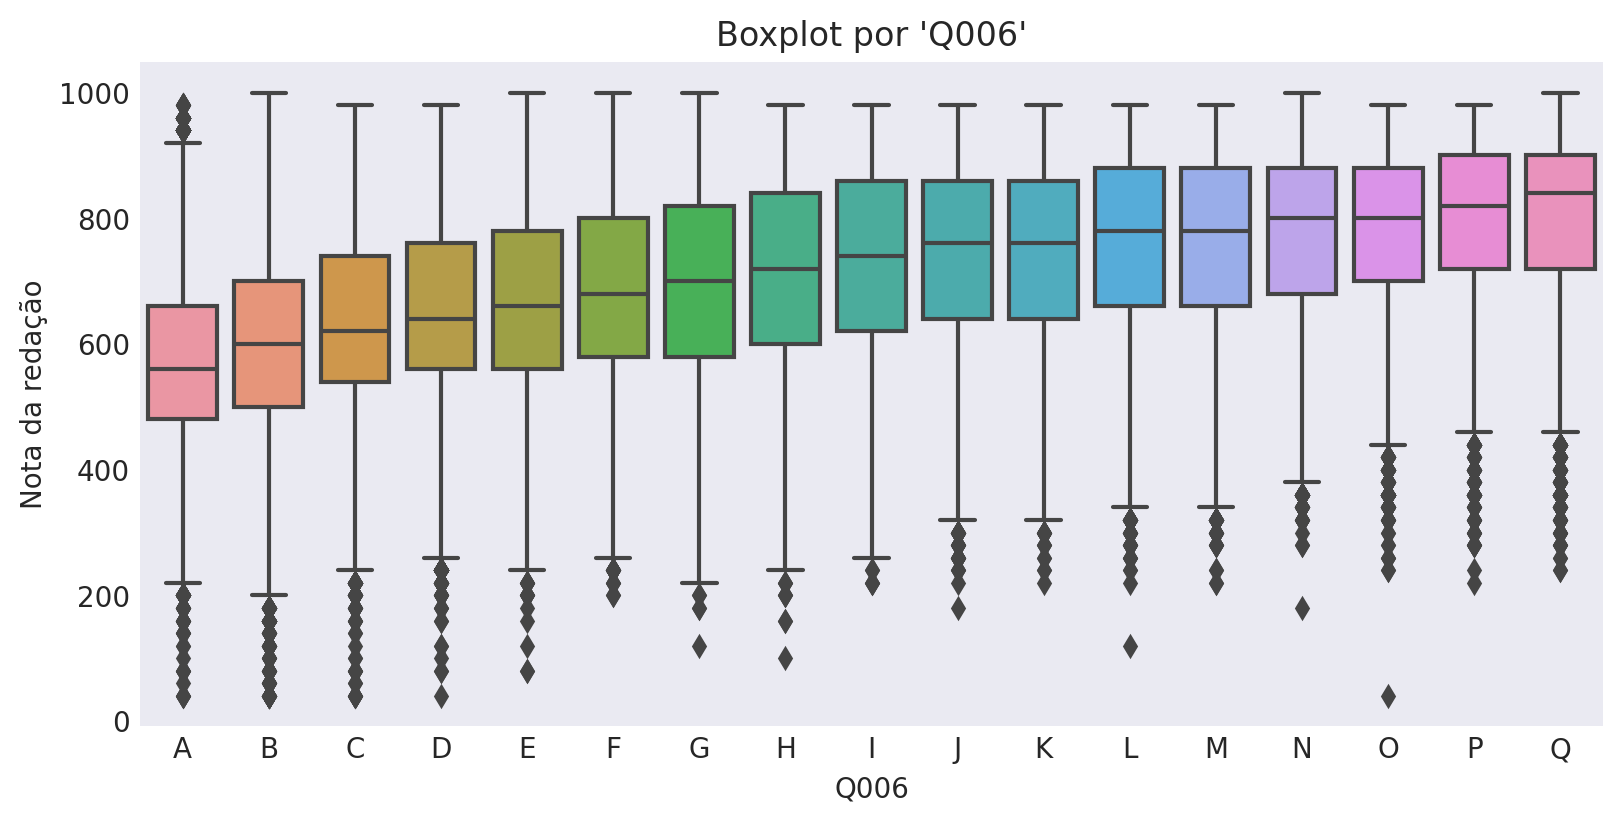

In [11]:
boxplot_category(df2022, 'Q006')

## Tipo de escola

Ao analisarmos a divisão dos indivíduos de acordo com o tipo de escola (pública ou privada), observamos que a proporção de alunos que frequentam escolas privadas é menor, representando cerca de 26,25% do total. No entanto, as notas obtidas pelos alunos de escolas privadas apresentam uma média e uma mediana mais altas em comparação aos alunos de escolas públicas.

O valor mínimo das notas para os alunos de escolas privadas está na faixa dos 400, excluindo os outliers, enquanto para os alunos de escolas públicas, o valor mínimo é próximo de 200. Embora existam notas máximas em ambas as classificações, as medidas mencionadas indicam que os alunos de escolas privadas tendem a ter notas melhores.

Esses resultados sugerem que o tipo de escola pode influenciar o desempenho dos alunos no exame, com os alunos de escolas privadas apresentando uma vantagem em relação às notas em comparação aos alunos de escolas públicas.

In [12]:
df2022.groupby('TP_ESCOLA')['NU_NOTA_REDACAO'].describe()

,count,mean,std,min,25%,50%,75%,max
TP_ESCOLA,,,,,,,,
Privado,173252.0,766.242929,133.988918,40.0,680.0,780.0,880.0,1000.0
Publico,486000.0,631.333827,151.561985,40.0,540.0,620.0,740.0,1000.0


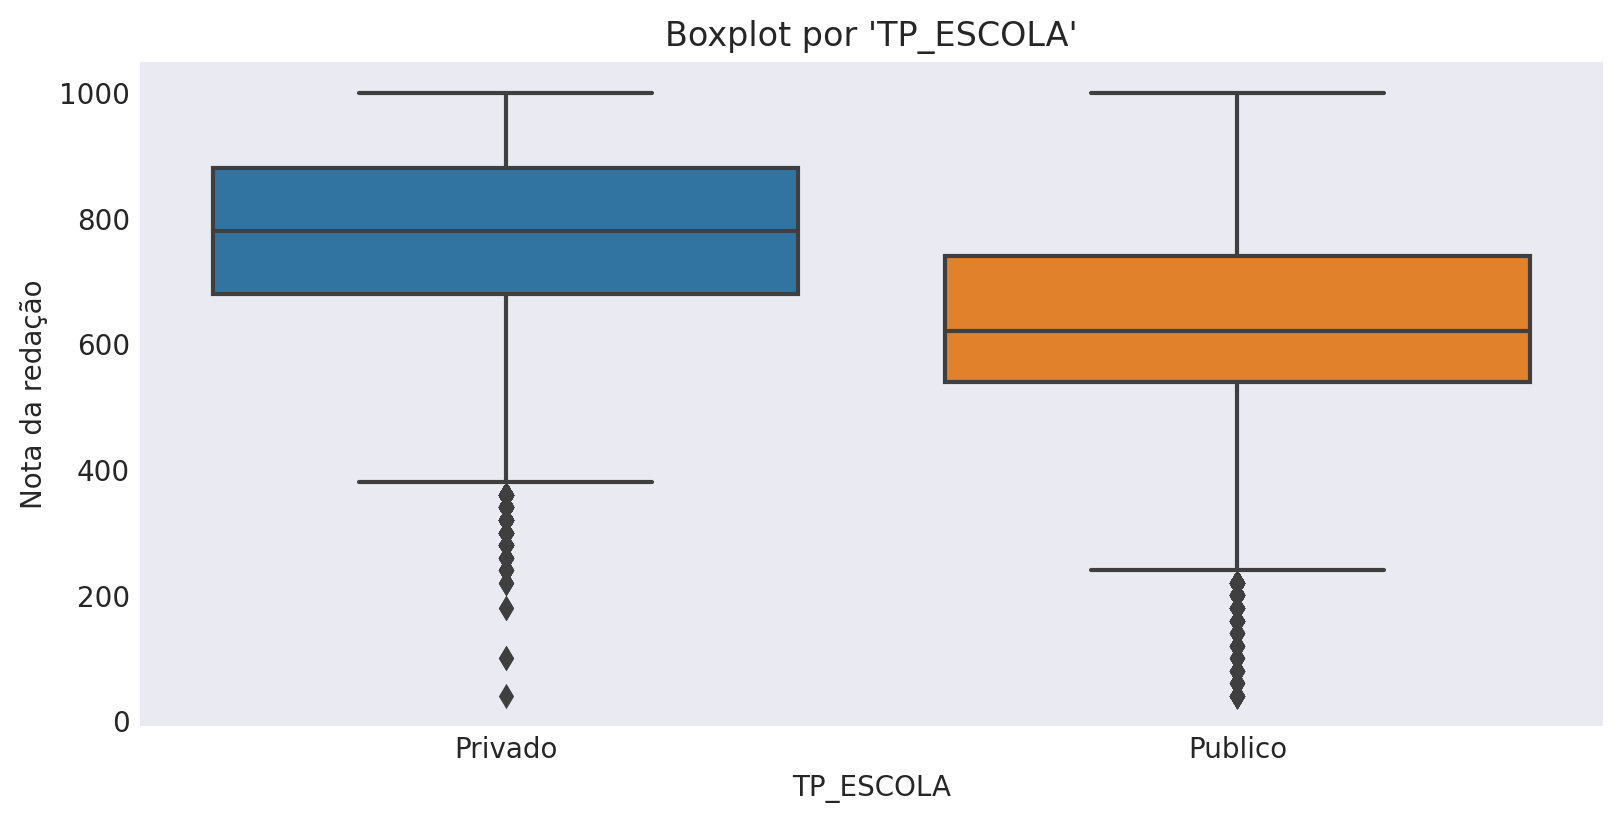

In [13]:
boxplot_category(df2022, str('TP_ESCOLA'))

## Unidade da federação

Ao considerarmos o aspecto regional e incluirmos o estado brasileiro onde cada inscrito vive, observamos que o estado de Minas Gerais se destaca com as melhores médias e medianas das notas de redação do ENEM. É o único estado que apresenta medidas superiores a 700, indicando um desempenho acima da média em relação aos demais estados.

Por outro lado, o estado do Amazonas se destaca com as menores notas, com valores inferiores a 600. Isso sugere que os estudantes desse estado enfrentam desafios adicionais ou possuem características específicas que impactam negativamente seu desempenho no exame.

Quanto aos demais estados, suas medidas variam entre 600 e 700, com diferenças no formato da distribuição e na amplitude das notas. Isso indica que o desempenho dos alunos nesses estados é mais homogêneo, porém com variações significativas dentro dessa faixa de pontuação.

In [14]:
df2022.groupby('SG_UF_ESC')['NU_NOTA_REDACAO'].describe()

,count,mean,std,min,25%,50%,75%,max
SG_UF_ESC,,,,,,,,
AC,2862.0,642.823201,161.336159,160.0,540.0,620.0,760.0,980.0
AL,10508.0,663.690522,163.661726,160.0,560.0,660.0,800.0,980.0
AM,12809.0,599.277071,146.505012,40.0,500.0,580.0,680.0,1000.0
AP,2698.0,637.257228,154.977367,220.0,540.0,620.0,760.0,980.0
BA,31850.0,670.668760,162.102845,40.0,560.0,660.0,800.0,1000.0
CE,62822.0,629.949699,171.212538,40.0,520.0,620.0,760.0,1000.0
DF,15306.0,676.390958,148.132894,160.0,580.0,660.0,800.0,1000.0
ES,14786.0,690.032463,157.398573,40.0,580.0,680.0,820.0,980.0
GO,26478.0,661.821890,167.208915,40.0,540.0,660.0,800.0,980.0


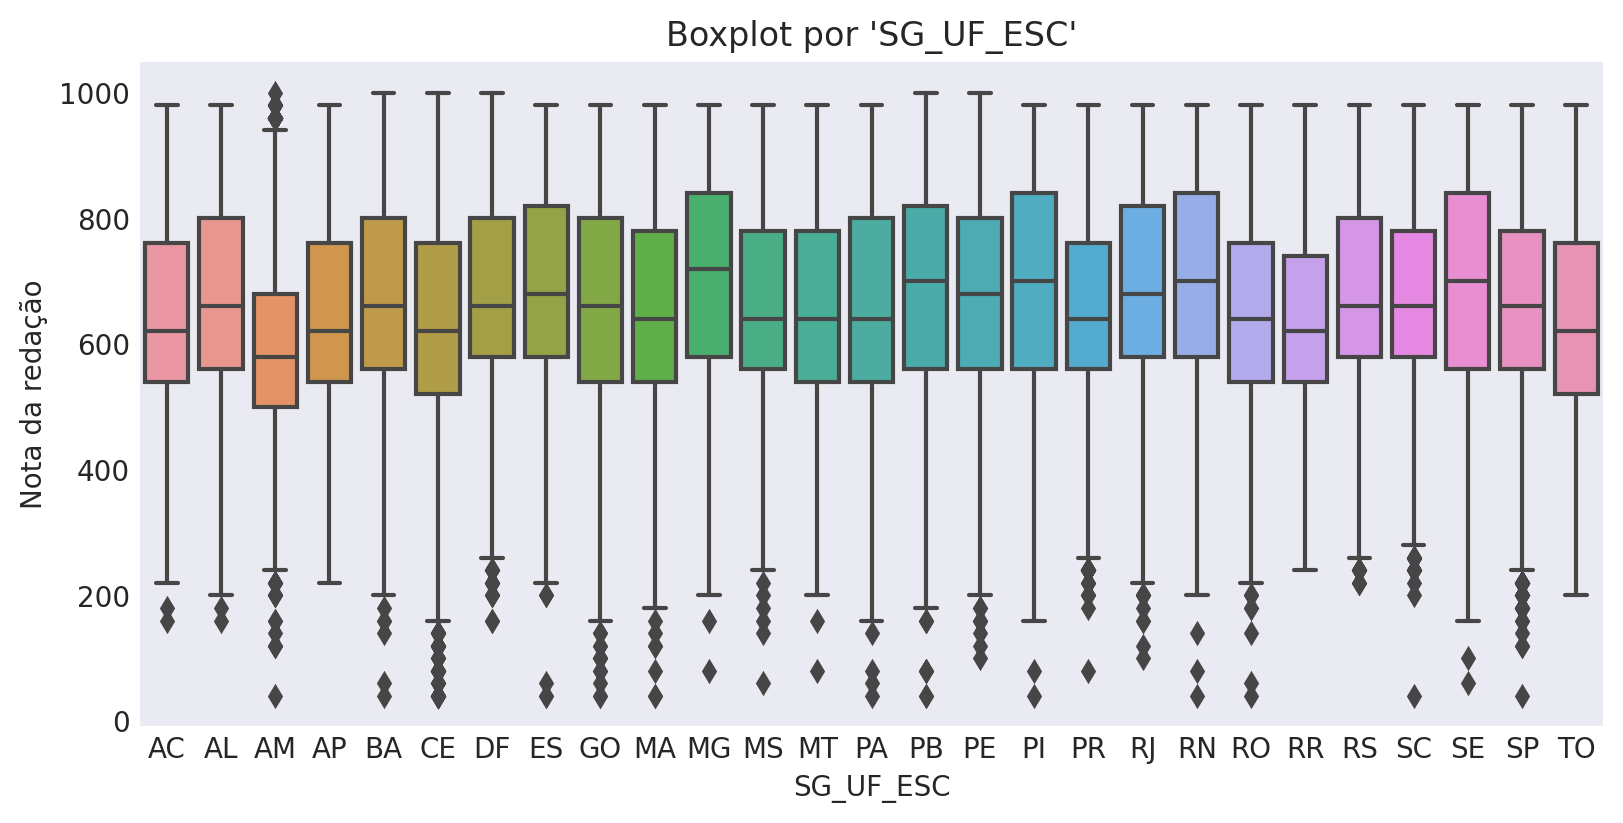

In [15]:
boxplot_category(df2022, str('SG_UF_ESC'))

# Em busca de um modelo

Para esta pesquisa, iremos utilizar modelos de aprendizado de máquina direcionados para regressão, a fim de prever a nota de redação do ENEM. Vamos comparar os resultados de quatro algoritmos conhecidos e analisar se suas regressões foram eficientes. Os modelos escolhidos são:

1. Random Forest:
   Este modelo é conhecido por combinar várias árvores de decisão independentes e realizar cálculos de média ou mediana para obter uma predição mais robusta.

2. Elastic Net:
   O Elastic Net é um método regressivo que combina as penalidades L1 (LASSO) e L2 (Ridge) para obter uma seleção de variáveis mais precisa e coeficientes estáveis.

#### Métodos com boosting

3. AdaBoost:
   O AdaBoost é um modelo que distribui pesos para modelos mais fracos e os combina para formar um modelo robusto, capaz de melhorar a precisão de previsões.

4. Gradient Boosting:
   O Gradient Boosting busca melhorar os resultados corrigindo os erros cometidos pelos modelos anteriores, utilizando uma abordagem de aprendizado por etapas.

Para avaliar o desempenho dos modelos, utilizaremos duas métricas de performance: o *RMSE* (Root Mean Square Error), que calcula a raiz quadrada do erro médio quadrático e está na mesma unidade da variável de interesse, e o *R²* (R-squared), que mede a proporção da variância explicada pelo modelo.

É importante ressaltar que a nota da redação do ENEM é aprensentada como uma medida discreta com valores naturais positivos. No entanto, para efeitos deste estudo, ela pode ser tratada como uma variável contínua, o que nos permite utilizar modelos regressivos para fazer as previsões.

In [5]:
# fuction to transform the variables (feactures) in dummy
def dummy_transform():
    df2022_x_dummies = pd.get_dummies(df2022[['TP_COR_RACA', 'TP_ESCOLA', 'SG_UF_ESC', 'Q006', 'NU_NOTA_REDACAO']])
    df2022_x_dummies = df2022_x_dummies.replace({False: 0, True: 1})
    df2022_x_dummies['NU_NOTA_REDACAO'] = df2022['NU_NOTA_REDACAO']
    return df2022_x_dummies

path_data = r'D:\OneDrive\DEV\Marchine learnig\Enem'

sep = r'/'

# models
models = ['Elastic Net', 'Random Forest', ' AdaBoost', 'Gradient Boosting']

def fun_metrics(y_test, y_pred, metrics, model_name):
    rmse = round(np.sqrt(mean_squared_error(y_test, y_pred)), 3)
    r2 = round(r2_score(y_test, y_pred), 3)

    dic_met = {
        'Modelo': [model_name],
        'RMSE': [rmse],
        'R²': [r2]
    }
    
    metric = pd.DataFrame(data=dic_met)
    metrics = pd.concat([metrics, metric])
    return metrics


def fun_models(models):
     os.makedirs(path_data + sep + 'Modelos', exist_ok=True)
     metrics = pd.DataFrame()
    
    # Split the data
     X_train, X_test, y_train, y_test = train_test_split(df2022.iloc[:, 1:52], df2022['NU_NOTA_REDACAO'], test_size=0.20, random_state=1612)

     for model_name in models:
        if model_name == 'Random Forest':
            model = RandomForestRegressor()

        elif model_name == 'Elastic Net':
            model = ElasticNet()

        elif model_name == 'AdaBoost':
            model = AdaBoostRegressor()
            
        elif model_name == 'Gradient Boosting':
            model = GradientBoostingRegressor()

        model.fit(X_train, y_train)

        pickle.dump(model, open(path_data + sep + 'Modelos' + sep + model_name.replace(" ", "_") + '.dat', 'wb'))

        y_pred = model.predict(X_test)

        metrics = fun_metrics(y_test, y_pred, metrics, model_name)

     metrics.to_csv(path_data + sep + 'Modelos' + sep + 'params.csv', index=False)
     return metrics

In [7]:
df2022 = dummy_transform()

In [6]:
resul_metrics = fun_models(models)
resul_metrics

,Modelo,RMSE,R²
0,Elastic Net,148.907,0.121
0,Random Forest,141.483,0.206
0,AdaBoost,141.477,0.206
0,Gradient Boosting,142.028,0.200


Com base nos modelos criados, observamos que nenhum deles apresentou um valor alto de R², indicando que os modelos não conseguiram capturar a variabilidade necessária para prever com precisão a nota de redação. Isso era esperado, uma vez que utilizamos variáveis mais generalistas que não abordam aspectos individuais mais específicos. Random Forest e AdaBoost apresentaram os resultados mais promissores, enquanto Elastic Net obteve o pior desempenho.

Em relação ao RMSE, obtivemos um resultado mediano. Considerando que estamos lidando com uma variável com uma amplitude de 1000 unidades, uma diferença média de 14,2% em relação à nota original é considerada razoável. Além disso, o valor do RMSE é menor do que o desvio-padrão da variável. Novamente, Random Forest e AdaBoost mostraram os melhores resultados nessa métrica.

## Neural Network


O último modelo que foi treinado consiste numa Rede Neural com 2 camadas escondidas. Neste caso, tem-se um modelo que possui um processo de aprendizagem o que torna a obtenção do resultado mais lento. Usaremos Pytorch para a criação do modelo. 

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df2022.iloc[:, 1:60], df2022['NU_NOTA_REDACAO'], test_size=0.20, random_state=1612)

# Standardizing data
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Convert to 2D arrays
y_train = y_train.to_numpy().reshape(-1, 1)
y_test = y_test.to_numpy().reshape(-1, 1)

# Convert to PyTorch tensors
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)

MSE: 20178
RMSE: 142.051027
R²: 0.199


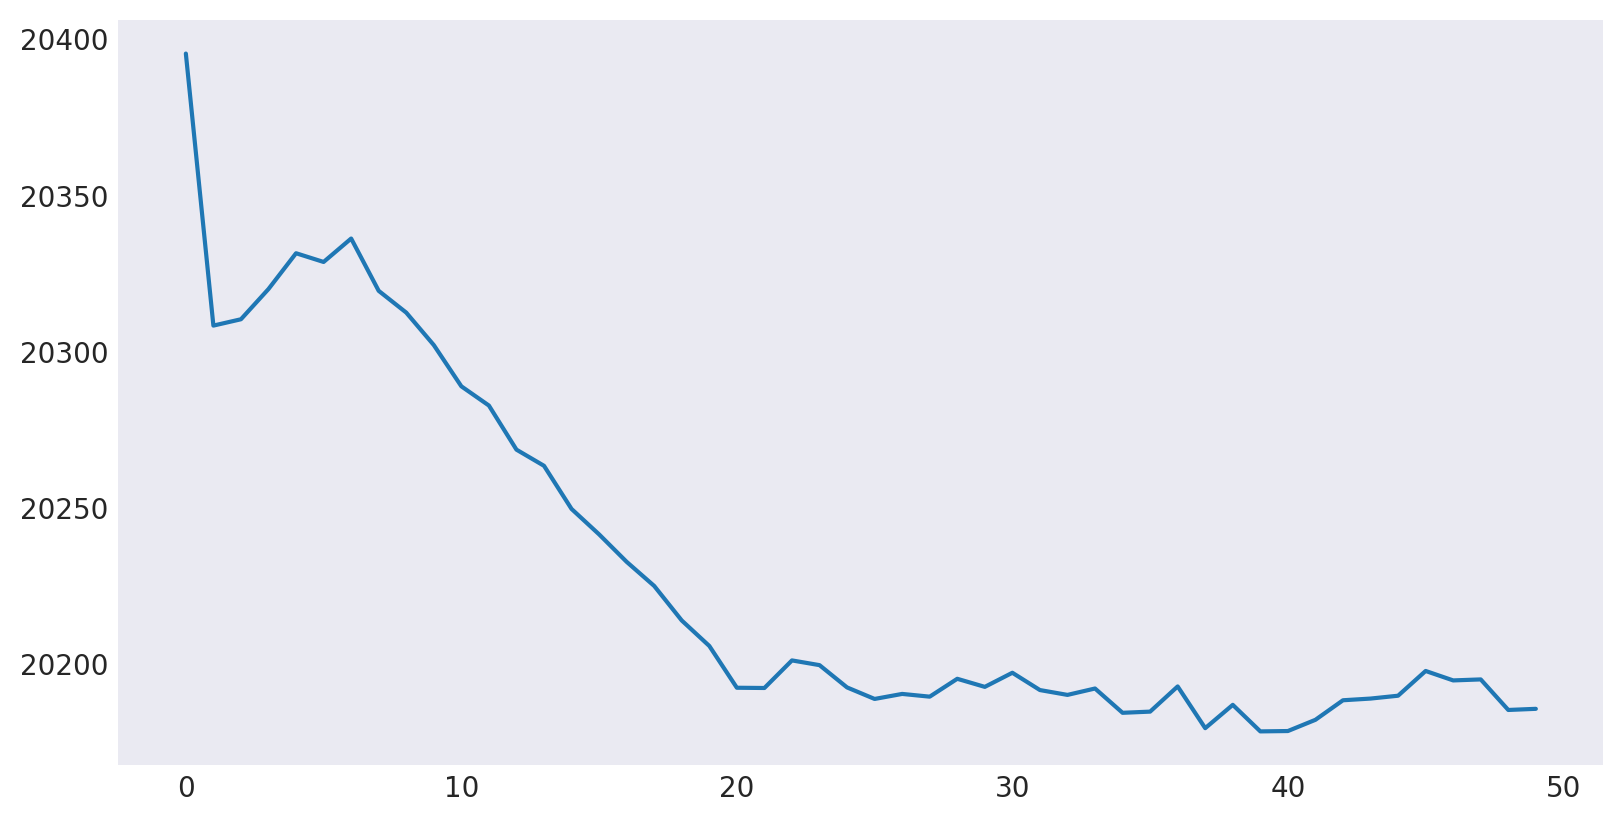

In [9]:
model_ann = nn.Sequential(
    nn.Linear(52, 60),
    nn.ReLU(),
    nn.Linear(60, 40),
    nn.ReLU(),
    nn.Linear(40, 20),
    nn.ReLU(),
    nn.Linear(20, 1)
)
# loss function and optimizer
loss_fn = nn.MSELoss()
optmizer = optim.Adam(model_ann.parameters(), lr = 0.001)

epochs = 50
batch_size = 5
batch_start = torch.arange(0, len(X_train), batch_size)

best_mse = np.inf
best_weights = None
history = []


for epoch in range(epochs):
    model_ann.train()
    with tqdm.tqdm(batch_start, unit = "batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model_ann(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optmizer.zero_grad()
            loss.backward()
            # update weights
            optmizer.step()
            # print progress
            bar.set_postfix(mse = float(loss))
    # evaluate accuracy in each epoch
    model_ann.eval()
    y_pred = model_ann(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        # base_weights = copy.deedcopy(model_ann.state_dict())

print("MSE: %2.f" % best_mse)
print("RMSE: %2f" % np.sqrt(best_mse))
r2 = r2_score(y_test.detach().numpy(), y_pred.detach().numpy())
r2_rounded = round(r2, 3)
print("R²:", r2_rounded)


fig, ax = plt.subplots(constrained_layout=True)
fig.set_size_inches(8, 4)
plt.plot(history)
plt.show()


O resultado apresentado por rede neural não conseguiu superar o modelo criado por RAndom Forest e Adaboost, sendo estes os mais recomendados como modelo regressivo 

# Análise Qualitativa

Na tentativa de obter um modelo mais eficiente e dinâmico para prever o nível dos alunos, foi realizada uma classificação com base nos resultados da redação. Para determinar os limites de cada classe, foi usado a distribuição das no histograma. Uma divisão simples considerando valores divisíveis por 1000 não seria adequada, pois não acompanha o formato da distribuição das notas. Portanto, a classificação foi definida da seguinte maneira:

- Classe A: notas maiores ou iguais a 850.
- Classe B: notas maiores ou iguais a 700 e menores que 850.
- Classe C: notas maiores ou iguais a 500 e menores que 700.
- Classe D: notas menores que 500.

Essa abordagem de classificação permite agrupar os alunos em diferentes categorias de acordo com o desempenho na redação do ENEM. Cada classe representa um nível específico de desempenho, o que facilita a análise e interpretação dos resultados.

In [9]:
# loadind the file
df2022 = loading_file()

In [10]:
df2022.loc[df2022['NU_NOTA_REDACAO'] >= 850, 'Rendimento'] = 'A'
df2022.loc[(df2022['NU_NOTA_REDACAO'] >= 700) & (df2022['NU_NOTA_REDACAO'] < 850), 'Rendimento'] = 'B'
df2022.loc[(df2022['NU_NOTA_REDACAO'] >= 500) & (df2022['NU_NOTA_REDACAO'] < 700), 'Rendimento'] = 'C'
df2022.loc[df2022['NU_NOTA_REDACAO'] < 500, 'Rendimento'] = 'D'

Em relação aos modelos, iremos utilizar os mesmos já utilizados para regressão, a exceção do Elastic Net, mas direcionados para classificação 

In [16]:
models_classifier = ['Random Forest', 'AdaBoost', 'Gradient Boosting']
y = df2022['Rendimento']
X = pd.get_dummies(df2022[['TP_SEXO', 'TP_COR_RACA', 'TP_ESCOLA', 'SG_UF_ESC', 'Q006']])

def fun_metricsClassifier(y_test, y_pred, metrics, model_name):
    Accuracy = round(accuracy_score(y_test, y_pred), 3)
    Precision = round(precision_score(y_test, y_pred, average='weighted'), 3)
    cm = confusion_matrix(y_test, y_pred)
    
    dic_met = {
        'Modelo': [model_name],
        'Acurásia': [Accuracy],
        'Precisão': [Precision],
    }

    metric = pd.DataFrame(data=dic_met)
    metrics = pd.concat([metrics, metric])
    

    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    ax.set_xticklabels(['A', 'B', 'C', 'D'])
    ax.set_yticklabels(['A', 'B', 'C', 'D'])
    plt.title('Matriz de Confusão - ' + model_name)
    plt.xlabel('Valores Previstos')
    plt.ylabel('Valores Reais')
    plt.show()
    
    
    return metrics

def fun__Classifier(models):
    metrics = pd.DataFrame()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=16)

    for model_name in models:
        if model_name == 'Random Forest':
            model = RandomForestClassifier()

        elif model_name == 'AdaBoost':
            model = AdaBoostClassifier()
            
        elif model_name == 'Gradient Boosting':
            model = GradientBoostingClassifier()

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        metrics = fun_metricsClassifier(y_test, y_pred, metrics, model_name)
    return metrics


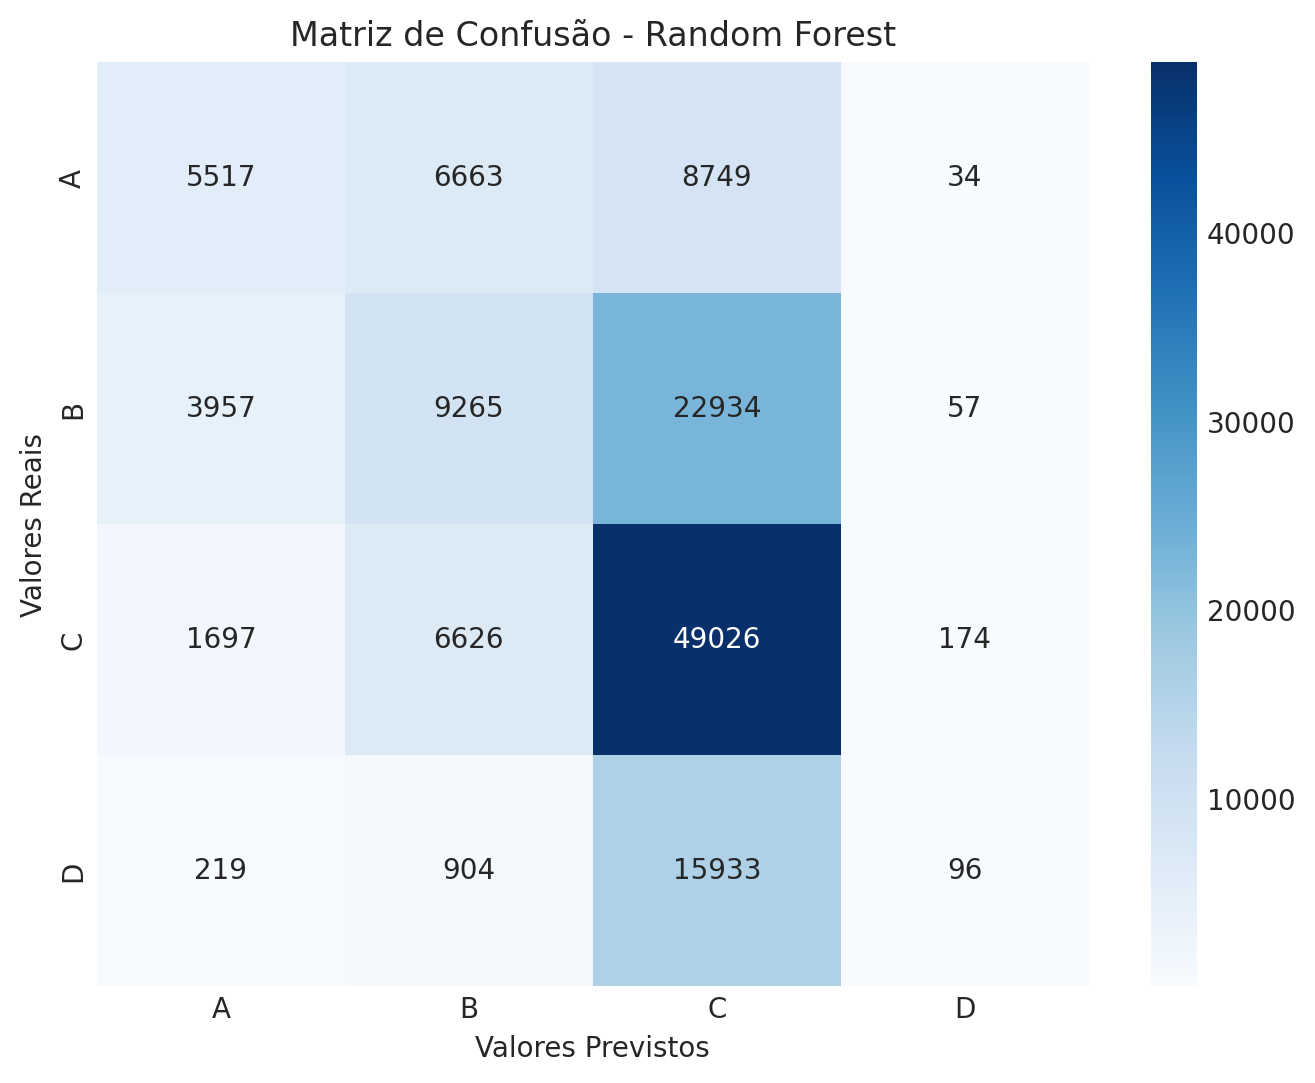

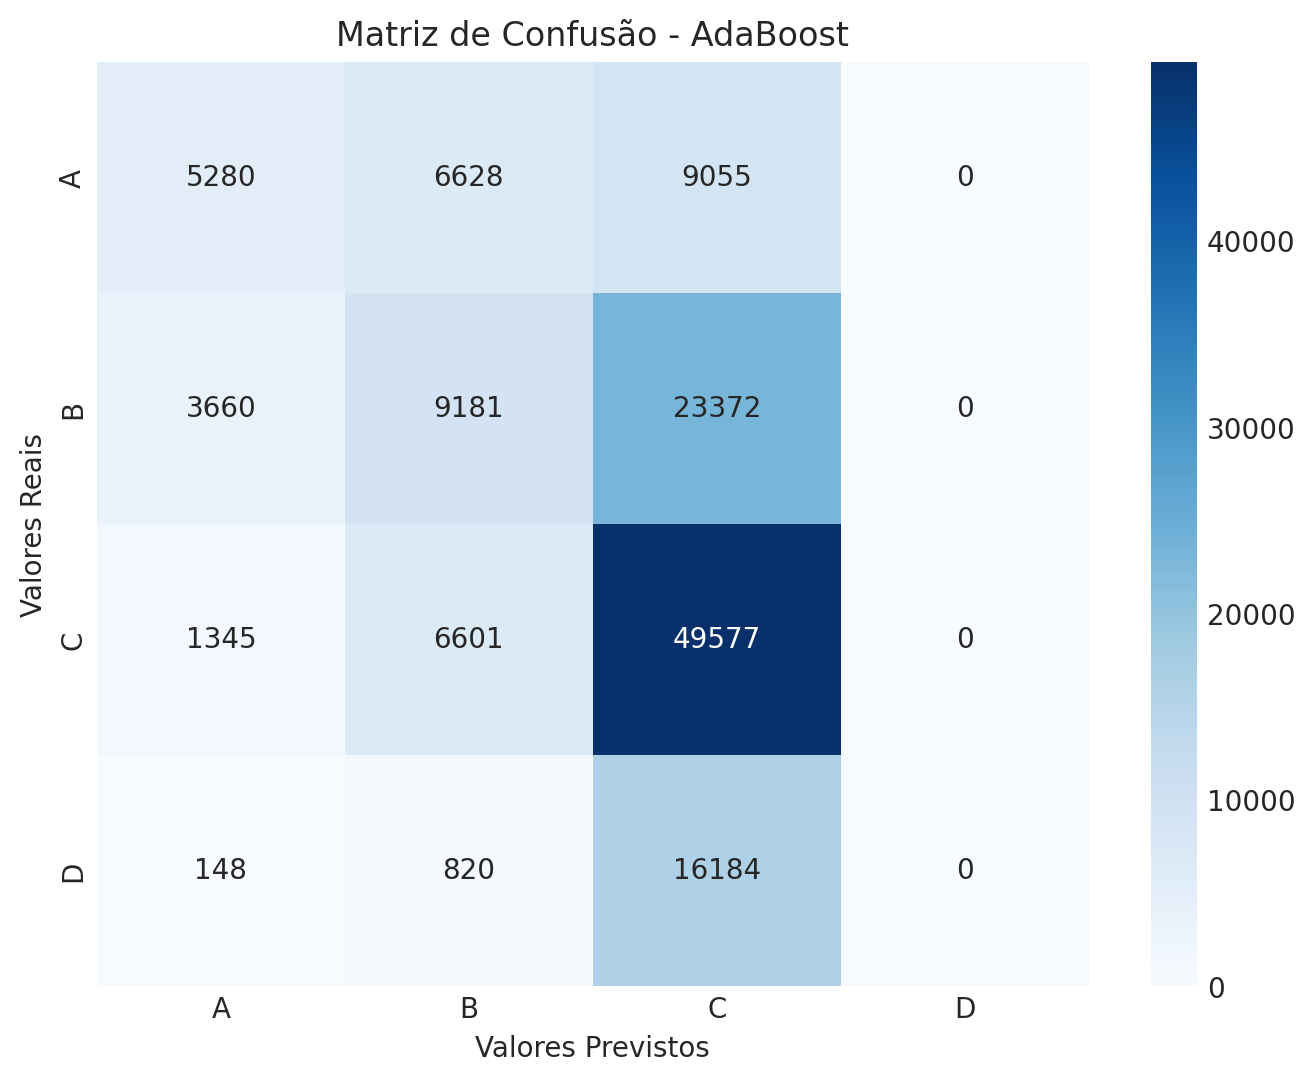

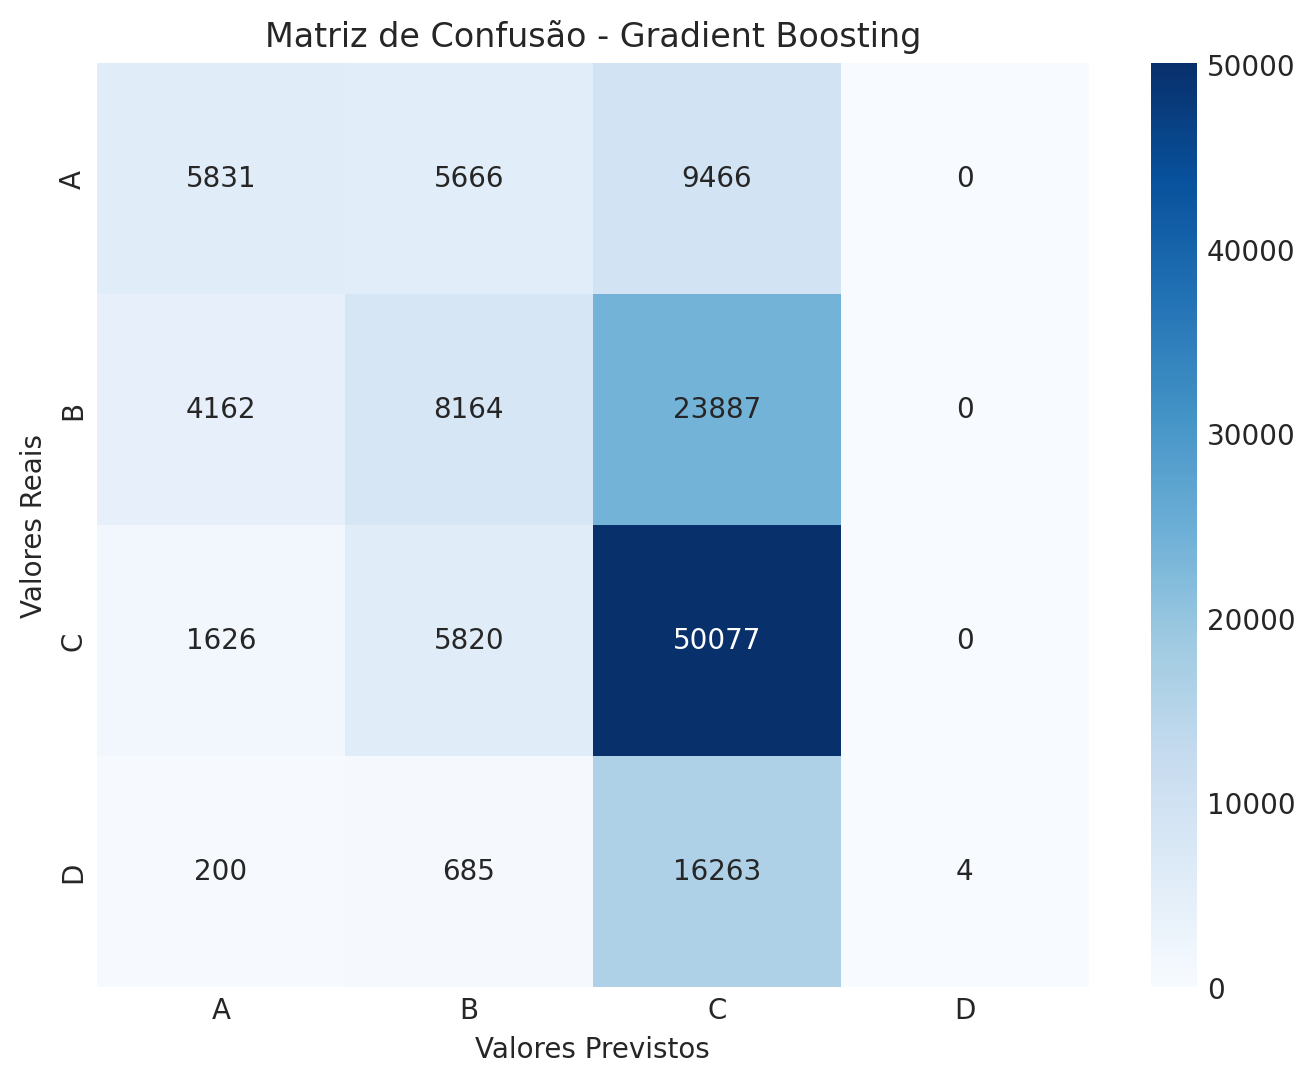

              Modelo  Acurásia  Precisão
0      Random Forest     0.485     0.441
0           AdaBoost     0.486     0.409
0  Gradient Boosting     0.486     0.538


In [17]:
metrics_classifier = fun__Classifier(models_classifier)
print(metrics_classifier)

Com base nos resultados obtidos, surge um impasse na seleção de um modelo para análise. Em termos de acurácia, os modelos apresentaram resultados semelhantes. No entanto, quando se trata de precisão, observa-se uma diferença significativa nos valores. A Random Forest apresentou o pior resultado, enquanto o Gradient Boosting obteve o melhor desempenho, com uma precisão de 0,53. Essa foi a única medida que ultrapassou 0,5.

Considerando esses resultados, o modelo escolhido para a análise é o Gradient Boosting, devido ao seu desempenho superior em termos de precisão, entretanto nenhum dos modelos obteve um resultado satifatório.

Tanto na regressão e na classificação, houveram dificências para encontrar os resultados. Certamente, um problema consistiu na falta de variáveis que possuam mais detalhes e informações não capturadas pela variáveis utilizadas aqui. 

# Extra - Upgrade da função de escolha modelo regressivo

A função abaixo é um upgrade da primeira função criada para encontrar os modelos regressivos, foi incluído a função GridSearchCV, que realiza interações entre os parâmetros para definir a melhor combinação. Esse acrescimo exige maior poder computacional e tempo para rodar os modelos

In [ ]:
# Upgrade the function regression models, but with computational requirement
def funUpgrade_models(models):
    os.makedirs(path_data + sep + 'Modelos', exist_ok=True)
    best_params = []
    metrics = pd.DataFrame()

        #split
    X_train, X_test, y_train, y_test = train_test_split(df2022.iloc[:,0:60], df2022['NU_NOTA_REDACAO'], test_size = 0.20, random_state=1612)

    # creating models
    for model in models:
        if model == 'Random Forest':
            forest_model  = RandomForestRegressor()
            param_grid = {'n_estimators': [25, 50, 100, 200],
                          'max_features': [2,3,4,5,6,8,12],
                          'oob_score': [True]}
            grid = GridSearchCV(forest_model, param_grid)
            grid.fit(X_train, y_train)
            model = RandomForestRegressor(**grid.best_params_)
            best_params.append(grid.best_params_)
            
        elif model == 'Elastic Net':
            elastic_model = ElasticNet()
            param_grid = {'alpha':[0.01, 0.1, 1, 10, 25, 50, 100],
                          'l1_ratio':[0.01, 0.1, 0.5, 0.95, 0.99,1]}
            grid = GridSearchCV(elastic_model, param_grid)
            grid.fit(X_train, y_train)
            model = ElasticNet(**grid.best_params_)
            best_params.append(grid.best_params_)           

        elif model == 'AdaBoost':
            ada_model = AdaBoostRegressor()
            param_grid = {'n_estimators':[5,10,20,25,50,75,100],
                          'learning_rate':[0.01,0.05,0.1,0.2,0.5]}
            grid = GridSearchCV(ada_model, param_grid)
            grid.fit(X_train, y_train)            
            model = AdaBoostRegressor(**grid.best_params_)
            best_params.append(grid.best_params_)           

        elif model == 'Gradient Boosting':
            grad_model = GradientBoostingRegressor()
            param_grid = {'n_estimators':[5,10,20,25,50,75],
                          'learning_rate':[0.01,0.05,0.1,0.2,0.5],
                          'max_depth': [3,4,5]}
            grid = GridSearchCV(grad_model, param_grid)
            grid.fit(X_train, y_train)               
            model = GradientBoostingRegressor(**grid.best_params_)
            best_params.append(grid.best_params_)           

    model.fit(X_train, y_train)

    pickle.dump(model, open(path_data + sep + 'Modelos' + sep + str(model) + '.dat'), 'wb')

    y_pred = model.predict(X_test)

    metrics = fun_metrics(y_test, y_pred, metrics, model)

    np.savetxt(path_data+sep+r'Modelos//params.csv', best_params, delimiter =', ', fmt ='% s')

    return metrics, best_params